In [1]:
TRAINING_WAVEFN_FOURIER_MODES = 2   # 1
TRAINING_TIME = 0.5                 # 0.5
TRAINING_INITIALS = 500             # 200
TRAINING_T_STEPS = 50              # 50
TRAINING_EPOCHS = 1000             # 100

MSE_HYPERPARAM = 1
SCHRODINGER_HYPERPARAM = 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

if device == "cuda":
    print(f"CUDA available. Using device \"{torch.cuda.get_device_name()}\".")
else:
    print(f"Using CPU device.")

CUDA available. Using device "NVIDIA GeForce GTX 1650 with Max-Q Design".


In [3]:
### NUMERICAL SIMULATOR ###
import scipy.integrate
def numerical_schrodinger(initials, ts, grid_size=100, grid_length=1):

    psi0 = initials[0:2, :, :]    
    v = initials[2, :, :]
    shape = psi0.shape
    flattened_shape = np.prod(shape)
    
    # flatten
    psi0 = np.reshape(psi0, flattened_shape)
    
    # construct laplacian operator and then Hamiltonian
    dx = grid_length/grid_size
    D2 = -2*np.eye(grid_size)
    for i in range(grid_size-1):
        D2[i,i+1] = 1 
        D2[i+1,i] = 1
    
    KE = -0.5*D2/(dx**2)
 
    def dpsi_dt(t,y):        
        y = np.reshape(y, shape)
        psi_real = y[0]
        psi_imag = y[1]
        dpsi_real = np.expand_dims(-KE@psi_imag - v*psi_imag, 0)
        dpsi_imag = np.expand_dims(KE@psi_real + v*psi_real, 0)
        return np.reshape(np.concatenate((dpsi_real, dpsi_imag), axis=0), flattened_shape)
    
    #sol = scipy.integrate.odeint(dpsi_dt, psi0, ts)
    sol = scipy.integrate.solve_ivp(dpsi_dt, t_span=[0,np.max(ts)], y0=psi0, t_eval=ts, method="RK23")
    
    return np.reshape(sol.y, shape+(len(ts),))

In [4]:
### TRAINING DATA ###
from tqdm import tqdm
import scipy.interpolate

class SimpleFiniteStepDataset(torch.utils.data.Dataset):
    def __init__(self, grid_size=100, grid_length=1, fourier_modes=TRAINING_WAVEFN_FOURIER_MODES, max_time=TRAINING_TIME, ntimes=TRAINING_T_STEPS, num_initials=TRAINING_INITIALS):
        self.grid_size = grid_size
        self.grid_length = grid_length
        self.fourier_modes = fourier_modes
        self.max_time = max_time
        self.ntimes = ntimes
        self.num_data = num_initials*ntimes*grid_size
        initials = np.empty((3, grid_size, num_initials))
        
        xs = np.linspace(0,grid_length,grid_size)
        
        print('Generating Initials')
        for i in range(num_initials):
            psi0_real, psi0_imag, v = self._generate_initial()
            initials[0, :, i] = psi0_real.T
            initials[1, :, i] = psi0_imag.T
            initials[2, :, i] = v.T
        print('Finished generating initials.')
        
        ts = np.linspace(0, max_time, ntimes)
        integrated = numerical_schrodinger(initials, ts, grid_size, grid_length)
        
        self.data = []
        
        print('the end bit is slow. Starting it now.')
        for i in range(self.num_data):
            a = i%self.ntimes                 # time index
            b = int(i/self.ntimes)%grid_size  # space index
            c = int(i/self.ntimes/grid_size)  # psi0 index
            
            x_real = initials[0,:,c]
            x_imag = initials[1,:,c]
            x_potl = initials[2,:,c]
            
            x = np.concatenate((np.array([xs[b], ts[a]]), x_real, x_imag, x_potl))
            
            y_real = integrated[0,b,c,a]
            y_imag = integrated[1,b,c,a]
            
            y = np.array([y_real, y_imag])
            
            x = torch.tensor(x).float()
            y = torch.tensor(y).float()
            
            self.data.append([x,y])
            
        print('did the end bit')
        
    def __len__(self):
        return self.num_data
    
    def __getitem__(self, index):    
        return self.data[index]
                
    def _generate_initial(self):
        
        # create the initial wave function
        fourier_real_coefficients = 2*np.random.rand(self.fourier_modes)-1
        fourier_imag_coefficients = 2*np.random.rand(self.fourier_modes)-1
        n = np.arange(start=1, stop=self.fourier_modes+1, step=1)

        scale_factor = np.sum(fourier_real_coefficients**2) + np.sum(fourier_imag_coefficients**2)
        scale_factor = (2/(self.grid_length*scale_factor))**0.5
        fourier_real_coefficients *= scale_factor
        fourier_imag_coefficients *= scale_factor
        
        def init_wave_function(x):
            x = np.pi*x/self.grid_length
            psi_real = np.sin(np.outer(x, n))
            psi_real = psi_real*fourier_real_coefficients
            psi_real = np.sum(psi_real, axis=-1)
            
            psi_imag = np.sin(np.outer(x, n))
            psi_imag = psi_imag*fourier_imag_coefficients
            psi_imag = np.sum(psi_imag, axis=-1)
            
            return psi_real, psi_imag
        
        
        # TODO: change when we have a better potential
        potential_function = lambda x: 0*x
        
        x = np.linspace(0, self.grid_length, self.grid_size)
        psi_real, psi_imag = init_wave_function(x)
        v = potential_function(x)
        
        return psi_real, psi_imag, v
        
    

In [5]:
# Generate training data
import time

print('Generating data...')
start = time.perf_counter()
data = SimpleFiniteStepDataset(grid_size=100, fourier_modes=TRAINING_WAVEFN_FOURIER_MODES, max_time=TRAINING_TIME, ntimes=TRAINING_T_STEPS, num_initials=TRAINING_INITIALS)
end = time.perf_counter()
print(f'Training data generated after {end-start} seconds!')

Generating data...
Generating Initials
Finished generating initials.
the end bit is slow. Starting it now.
did the end bit
Training data generated after 129.8712599670107 seconds!


In [6]:
### MODEL DEFN ###
class SimpleFiniteStepSolver(nn.Module):
    def __init__(self, grid_size=100, hidden_dim=20):
        super(SimpleFiniteStepSolver, self).__init__()
        
        self.grid_size = grid_size

        self.mlp = nn.Sequential(
            nn.Linear(3*grid_size+2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.mlp(x)

In [12]:
# Try to train
from tqdm import tqdm
import matplotlib.pyplot as plt # DEBUG TMP

nepochs = TRAINING_EPOCHS
model = SimpleFiniteStepSolver(grid_size=100, hidden_dim=300).to(device)

train_data_loader = torch.utils.data.DataLoader(data, batch_size=1000, shuffle=True)

optm = torch.optim.Adam(model.parameters(), lr = 0.01)

mse_hyperparam = 1
schrod_hyperparam = 0.01

grid_size = model.grid_size
def schrodinger_loss(output, inputs):
    batch_size = output.shape[0]
    
    psi_real = output[:,0]
    psi_imag = output[:,1]
    
    # Calculate Laplacian
    dx = 1e-2 # TODO Make sure the precsion of this is no less than the precision of input
    inputs_x_minus = inputs.clone()
    inputs_x_minus[:,0] -= dx
    inputs_x_plus = inputs.clone()
    inputs_x_plus[:,0] += dx
    
    psi_x_minus = model(inputs_x_minus)
    psi_x_plus = model(inputs_x_plus)
    psi_d2x = (psi_x_plus + psi_x_minus - 2*output)/(dx**2)
    
    psi_d2x_real = psi_d2x[:,0]
    psi_d2x_imag = psi_d2x[:,1]
    
    # Calculate time derivative
    dt = 1e-5
    inputs_t_minus = inputs.clone()
    inputs_t_minus[:,1] -= dt
    inputs_t_plus = inputs.clone()
    inputs_t_plus[:,1] += dt
    
    psi_t_minus = model(inputs_t_minus)
    psi_t_plus = model(inputs_t_plus)
    
    psi_dt = (psi_t_plus - psi_t_minus)/(2*dt)
    
    psi_dt_real = psi_dt[:,0]
    psi_dt_imag = psi_dt[:,1]
    
    # Calculate potential energy
    V_grid = inputs[:,2*grid_size+1:]
    pos = (inputs[:,0]*(grid_size-1)).type(torch.IntTensor).to(device)
    V = torch.index_select(V_grid,1,pos)
    
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # Calculate loss
    diff_1 = psi_dt_real - 0.5*psi_d2x_imag + V_imag
    diff_2 = psi_dt_imag + 0.5*psi_d2x_real - V_real

    return torch.sum(diff_1**2 + diff_2**2)/batch_size


def custom_loss(output, in_put, target):
    mse =  F.mse_loss(output,y)
    schrod_loss = schrodinger_loss(output, in_put) if schrod_hyperparam != 0 else 0
    
    return mse + schrod_hyperparam*schrod_loss
    

for epoch in range(nepochs):
    epoch_loss = 0
    
    for x,y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        
        optm.zero_grad()
        output = model(x)
        #loss = F.mse_loss(output,y)        
        loss = custom_loss(output,x,y)
        
        loss.backward()
        optm.step()
        
        epoch_loss+=loss/len(train_data_loader)
        
    print('Epoch {} Loss : {:.3e}'.format((epoch+1),epoch_loss))

100%|██████████| 2500/2500 [00:44<00:00, 55.87it/s]


Epoch 1 Loss : 3.965e-01


100%|██████████| 2500/2500 [00:39<00:00, 62.55it/s]


Epoch 2 Loss : 3.890e-01


100%|██████████| 2500/2500 [00:39<00:00, 64.09it/s]


Epoch 3 Loss : 3.922e-01


100%|██████████| 2500/2500 [01:02<00:00, 40.25it/s]


Epoch 4 Loss : 3.922e-01


100%|██████████| 2500/2500 [00:49<00:00, 50.87it/s]


Epoch 5 Loss : 3.927e-01


100%|██████████| 2500/2500 [01:07<00:00, 36.81it/s]


Epoch 6 Loss : 3.923e-01


100%|██████████| 2500/2500 [00:45<00:00, 54.63it/s]


Epoch 7 Loss : 3.922e-01


100%|██████████| 2500/2500 [00:51<00:00, 48.92it/s]


Epoch 8 Loss : 3.924e-01


100%|██████████| 2500/2500 [01:11<00:00, 34.85it/s]


Epoch 9 Loss : 3.927e-01


100%|██████████| 2500/2500 [00:52<00:00, 47.80it/s]


Epoch 10 Loss : 3.929e-01


100%|██████████| 2500/2500 [00:54<00:00, 45.48it/s]


Epoch 11 Loss : 3.923e-01


100%|██████████| 2500/2500 [00:53<00:00, 47.11it/s]


Epoch 12 Loss : 3.929e-01


100%|██████████| 2500/2500 [00:50<00:00, 49.34it/s]


Epoch 13 Loss : 3.928e-01


 99%|█████████▉| 2469/2500 [00:52<00:00, 47.34it/s]


KeyboardInterrupt: 

In [8]:
steps = 25
T = TRAINING_TIME
ts = np.linspace(0,T,steps)

grid_length = 1
grid_size = model.grid_size

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def solve_single_numerically(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs_num = np.linspace(0,grid_length,grid_size)
    p0_real, p0_imag = psi0(xs_num)
    vs = v(xs_num)
    
    initials = np.zeros((3, grid_size, 1))
    initials[0, :, 0] = p0_real.T
    initials[1, :, 0] = p0_imag.T
    initials[2, :, 0] = vs.T
    
    num_y = numerical_schrodinger(initials, ts, grid_size=grid_size)
    
    num_ys_real = num_y[0,:,0,:]
    num_ys_imag = num_y[1,:,0,:]
    
    return num_ys_real.T, num_ys_imag.T


def solve_single_nn(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs = torch.linspace(0, grid_length, grid_size).float()
    ts = torch.tensor(ts).float()
    p0_real, p0_imag = psi0(xs)
    vs = v(xs)
    
    if not torch.is_tensor(ts):
        ts = torch.tensor(ts)
        
    xts = torch.cartesian_prod(xs,ts)
#     xs_meshed = xts[:,0]
#     ts_meshed = xts[:,1]
    
    nn_in = torch.zeros((len(xts), 3*grid_size + 2))
    nn_in[:,0:2] = xts
    nn_in[:,2:] = torch.cat((p0_real, p0_imag, vs))
    nn_in = nn_in.to(device)
    
    nn_out = model(nn_in).cpu().detach().numpy()
    
    out_real = np.reshape(nn_out[:,0], (grid_size, len(ts))).T
    out_imag = np.reshape(nn_out[:,1], (grid_size, len(ts))).T 
    
    return out_real, out_imag
    

def test_model(psi0, v, plot_phase=False):
    # Solve numerically
    print('Solving numerically...')
    num_ys_real,num_ys_imag = solve_single_numerically(psi0, v, ts, grid_size, grid_length)
    print('Finished solving numerically.')
   
    # Solve using our method
    print('Solving nn...')
    nn_ys_real, nn_ys_imag = solve_single_nn(psi0, v, ts, grid_size, grid_length)
    print('Finished solving nn.')
    
    xs = np.linspace(0, grid_length, grid_size)
    
    # Normalisation vs time
    fig = plt.figure(figsize=(5,5))
    plt.plot(ts, np.sum(nn_ys_real**2 + nn_ys_imag**2, axis=1)*grid_length / grid_size)
    fig.suptitle('Normalisation')
    plt.xlabel('Time')
    plt.ylabel('∫|Ψ|² dx')
    
    # Plot animations
    fig = plt.figure(figsize=(12,8))
    
    plt.rcParams["animation.html"] = "html5"
    plt.rcParams["figure.dpi"] = 75
    
    # Helper for setting up subplot limits and labels
    def setup_subplot(subplot, prop):
        prop = prop.upper()
        if not prop in ["REAL", "IMAG", "ABS", "PHASE"]:
            raise ValueError(f'Bad property \'{prop}\'.')
        subplot.set_xlim(0,grid_length)
        if prop in ["REAL", "IMAG"]:
            subplot.set_ylim(-2,2)
            subplot.set_ylabel("Real" if prop == "REAL" else "Imaginary")
        if prop == "ABS":
            subplot.set_ylim(0,2)
            subplot.set_ylabel("Magnitude")
        if prop == "PHASE":
            subplot.set_ylim(-np.pi,np.pi)
            subplot.set_ylabel("Phase")
            subplot.set_yticks(np.arange(-np.pi,np.pi,np.pi/4))
        
        line, = subplot.plot([],[], lw=2)
        return line
    
    # Types of each subplot
    props = [None]*4
    if plot_phase:
        props = ["ABS", "ABS", "PHASE", "PHASE"]
    else:
        props = ["REAL", "REAL", "IMAG", "IMAG"]
       
    subplots = [None]*4
    lines = [None]*4
    for i in range(4):
        subplots[i] = plt.subplot(2,2,i+1)
        lines[i] = setup_subplot(subplots[i], props[i])
        
    subplots[0].title.set_text('NN model')
    subplots[1].title.set_text('Numerical model')
    
    def animate(i):
        if plot_phase:
            lines[0].set_data(xs, np.sqrt(nn_ys_real[i,:]**2 + nn_ys_imag[i,:]**2))
            lines[2].set_data(xs, np.arctan2(nn_ys_real[i,:], nn_ys_imag[i,:]))
        
            lines[1].set_data(xs, np.sqrt(num_ys_real[i,:]**2 + num_ys_imag[i,:]**2))
            lines[3].set_data(xs, np.arctan2(num_ys_real[i,:], num_ys_imag[i,:]))

        else:
            lines[0].set_data(xs, nn_ys_real[i,:])
            lines[2].set_data(xs, nn_ys_imag[i,:])
            
            lines[1].set_data(xs, num_ys_real[i,:])
            lines[3].set_data(xs, num_ys_imag[i,:])

        return lines
    
    anim = animation.FuncAnimation(fig, animate, frames=len(ts), interval=50, blit=True)
    HTML(anim.to_html5_video())
    return anim

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


/usr/local/lib/python3.8/dist-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


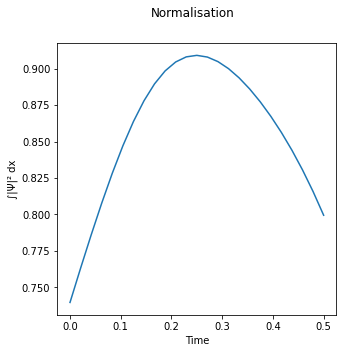

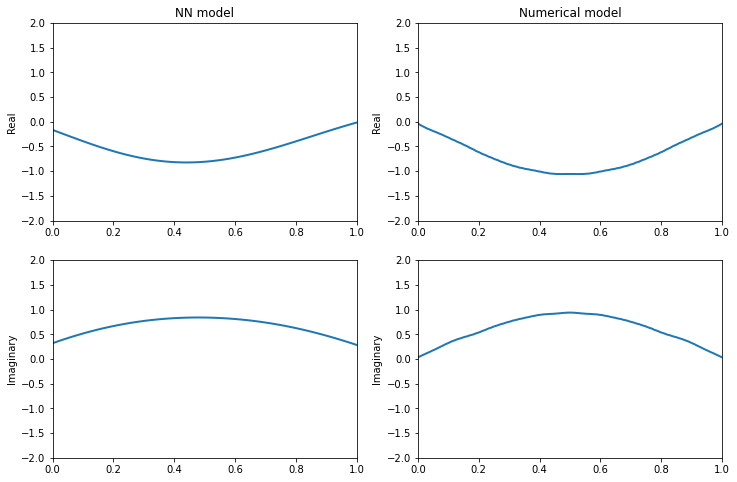

In [9]:
# Particle in a Box Ground State - Real+Imag

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


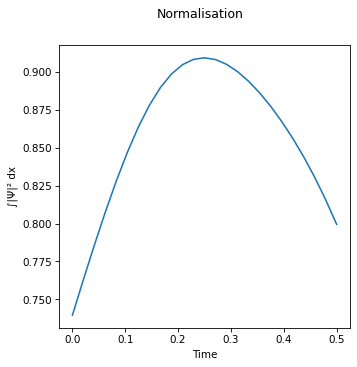

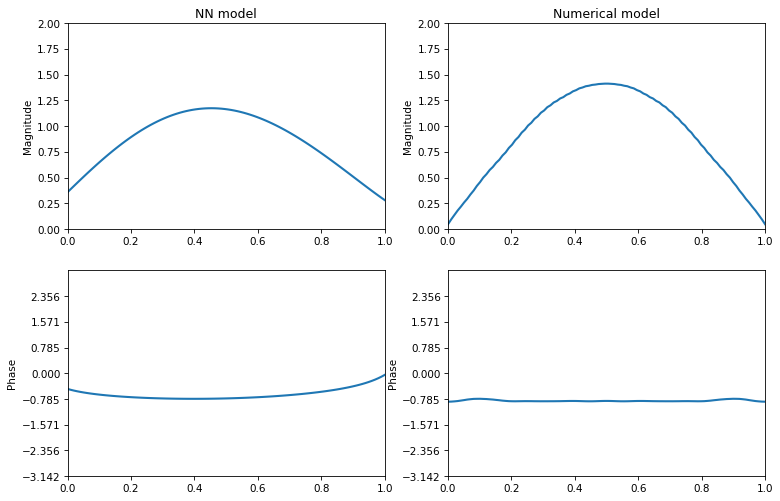

In [10]:
# Particle in a Box Ground State - Amplitude+Phase

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=True)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


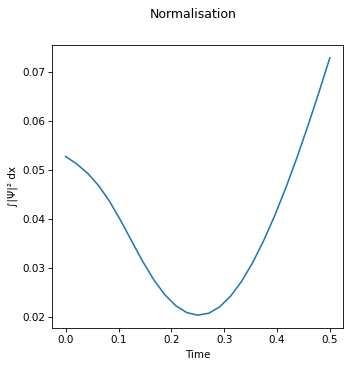

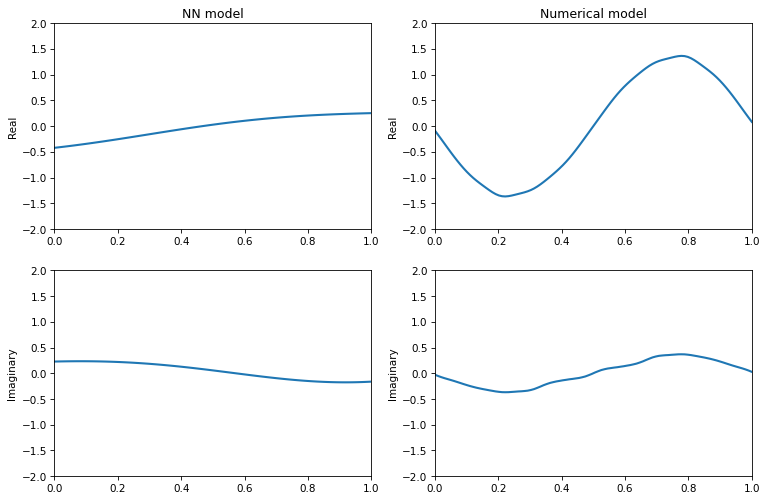

In [11]:
# Particle in a Box - First Excited State

def psi0(x):
    real = np.sqrt(2)*np.sin(2*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [ ]:
# Test our model's schrodinger loss.

# Input conditions for simple lowest-energy particle in a box.
N = 1000

inputs = torch.zeros((N,302), requires_grad=True).to(device)

# set xs
xs = np.linspace(0,1,N)
xs_torch = torch.linspace(0,1,N)
inputs[:,0] = torch.linspace(0,1,N)

# set ts
inputs[:,1] = 0.05

# set psi_R
xs_sample = torch.linspace(0,1,100)
inputs[:,2:102] = np.sqrt(2)*torch.sin(xs_sample*np.pi)

# set psi_I and V
inputs[:,102:] = 0

batch_size = inputs.shape[0]

output = model(inputs)
output_np = output.cpu().detach().numpy()

plt.figure()
plt.plot(xs, output_np[:,0])
plt.plot(xs, output_np[:,1])
plt.title('wavefn')
plt.show()

psi_real = output[:,0]
psi_imag = output[:,1]

# Calculate Laplacian
dx = 1e-2 # TODO Make sure the precsion of this is no less than the precision of input
inputs_x_minus = inputs.clone()
inputs_x_minus[:,0] -= dx
inputs_x_plus = inputs.clone()
inputs_x_plus[:,0] += dx

psi_x_minus = model(inputs_x_minus)
psi_x_plus = model(inputs_x_plus)
psi_d2x = (psi_x_plus + psi_x_minus - 2*output)/(dx**2)

psi_dx = (psi_x_plus - psi_x_minus)/(2*dx)
psi_dx_real = psi_dx[:,0]
psi_dx_imag = psi_dx[:,1]

psi_d2x_real = psi_d2x[:,0]
psi_d2x_imag = psi_d2x[:,1]

plt.figure()
plt.plot(xs, psi_dx_real.cpu().detach().numpy())
plt.plot(xs, psi_dx_imag.cpu().detach().numpy())
plt.title('psi_dx')
plt.show()

plt.figure()
plt.plot(xs, psi_d2x_real.cpu().detach().numpy())
plt.plot(xs, psi_d2x_imag.cpu().detach().numpy())
plt.title('psi_d2x')
plt.show()

# Calculate time derivative
dt = 1e-5
inputs_t_minus = inputs.clone()
inputs_t_minus[:,1] -= dt
inputs_t_plus = inputs.clone()
inputs_t_plus[:,1] += dt

psi_t_minus = model(inputs_t_minus)
psi_t_plus = model(inputs_t_plus)

psi_dt = (psi_t_plus - psi_t_minus)/(2*dt)

psi_dt_real = psi_dt[:,0]
psi_dt_imag = psi_dt[:,1]

plt.figure()
plt.plot(xs, psi_dt_real.cpu().detach().numpy())
plt.plot(xs, psi_dt_imag.cpu().detach().numpy())
plt.title('psi_dt')
plt.show()

# Calculate potential energy
# TODO zero for now
# V_grid = inputs[:,2*grid_size+1:]
# pos = (inputs[:,0]*(grid_size-1)).type(torch.IntTensor).to(device)
# V = torch.index_select(V_grid,1,pos)
V = 0

#print(psi_dt_real.shape)
#print(V.shape)

V_real = V * psi_real
V_imag = V * psi_imag

# Calculate loss
diff_1 = psi_dt_real - 0.5*psi_d2x_imag + V_imag
diff_2 = psi_dt_imag + 0.5*psi_d2x_real - V_real


plt.figure()
plt.plot(xs, psi_dt_real.cpu().detach().numpy())
plt.plot(xs, 0.5*psi_d2x_imag.cpu().detach().numpy())
plt.plot(xs, diff_1.cpu().detach().numpy())
plt.title('diff_1')
plt.show()

plt.figure()
plt.plot(xs, psi_dt_imag.cpu().detach().numpy())
plt.plot(xs, -0.5*psi_d2x_real.cpu().detach().numpy())
plt.plot(xs, diff_2.cpu().detach().numpy())
plt.title('diff_2')
plt.show()

plt.figure()
plt.plot(xs, V_real.cpu().detach().numpy())
plt.plot(xs, V_imag.cpu().detach().numpy())
plt.title('V')
plt.show()